In [25]:
from TwoLink_v0 import TwoLinkManipulatorEnv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import random
from collections import deque
from tensorflow.keras.optimizers import Adam


In [27]:
# Create the environment
env = TwoLinkManipulatorEnv()  # Set rendering on
state, _ = env.reset()


# Environment parameters
state_size = env.observation_space.shape[0]  # State space dimensions
action_size = env.action_space.n  # Number of discrete actions
goal_position = env.goal  # Target position (predefined in the environment)
print (state_size, action_size, goal_position)

5 9 [0.8164 1.7509]


In [28]:

# Hyperparameters
num_episodes = 200
max_steps_per_episode = 100
gamma = 0.95  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.99
epsilon_min = 0.01
batch_size = 16
target_update_frequency = 5  # Update target network every 5 episodes
replay_buffer = deque(maxlen=10000)  # Experience replay buffer



In [29]:
# Build the Q-network
def build_model():
    model = Sequential([
        Dense(24, activation='relu', input_shape=(5,)),
        Dense(24, activation='relu'),
        Dense(action_size, activation='linear')  # Q-values for each action
    ])
    model.compile(optimizer = 'Adam', loss='mse')
    return model


In [30]:
success = []
Reward = []
# Instantiate main and target models
main_model = build_model()
target_model = build_model()
target_model.set_weights(main_model.get_weights())  # Initialize target model weights
main_model.summary()
target_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 24)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969 (3.79 KB)

 Trainable params: 969 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 24)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 9)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969 (3.79 KB)

 Trainable params: 969 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:

# Training loop
for episode in range(num_episodes):
    state, _ = env.reset()  # Reset environment and get initial state
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    time_step = 0

    while not done and time_step < 100:
        # Epsilon-greedy action selection
        action = np.argmax(main_model.predict(state, verbose=0))  # Exploit learned policy

        # Take the selected action
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Store experience in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))

        # Update state and accumulate reward
        state = next_state
        total_reward += reward
        time_step += 1
                
        # Perform experience replay if replay buffer has enough samples
        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

            batch_state = np.vstack(batch_state)
            batch_next_state = np.vstack(batch_next_state)

            # Predict Q-values for current and next states
            target = main_model.predict(batch_state, verbose=0)
            target_next = target_model.predict(batch_next_state, verbose=0)

            # Update Q-values using the Bellman equation
            for i in range(batch_size):
                if batch_done[i]:
                    target[i][batch_action[i]] = batch_reward[i]
                else:
                    target[i][batch_action[i]] = batch_reward[i] + gamma * np.amax(target_next[i])

            # Train the main model
            main_model.fit(batch_state, target, batch_size=batch_size, verbose=0)

    # Update target model periodically
    if (episode + 1) % target_update_frequency == 0:
        target_model.set_weights(main_model.get_weights())

    # Decay exploration rate
    #epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Log progress
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}, Steps: {time_step}, Epsilon: {epsilon:.2f}")
    if time_step == 100:
        success.append(0)
    else:
        success.append(1)
    Reward.append(total_reward)

# Close the environment
env.close()


Episode 1/200, Total Reward: -170.89, Steps: 100, Epsilon: 1.00
Episode 2/200, Total Reward: 43.66, Steps: 61, Epsilon: 1.00
Episode 3/200, Total Reward: -182.51, Steps: 100, Epsilon: 1.00
Episode 4/200, Total Reward: -215.17, Steps: 100, Epsilon: 1.00
Episode 5/200, Total Reward: -189.38, Steps: 100, Epsilon: 1.00
Episode 6/200, Total Reward: -179.05, Steps: 100, Epsilon: 1.00
Episode 7/200, Total Reward: -137.07, Steps: 100, Epsilon: 1.00
Episode 8/200, Total Reward: -114.99, Steps: 100, Epsilon: 1.00
Episode 9/200, Total Reward: -108.63, Steps: 100, Epsilon: 1.00
Episode 10/200, Total Reward: -100.05, Steps: 100, Epsilon: 1.00
Episode 11/200, Total Reward: -93.04, Steps: 100, Epsilon: 1.00
Episode 12/200, Total Reward: -86.00, Steps: 100, Epsilon: 1.00
Episode 13/200, Total Reward: -79.06, Steps: 100, Epsilon: 1.00
Episode 14/200, Total Reward: -64.16, Steps: 100, Epsilon: 1.00
Episode 15/200, Total Reward: 93.60, Steps: 9, Epsilon: 1.00
Episode 16/200, Total Reward: 93.60, Steps: 9

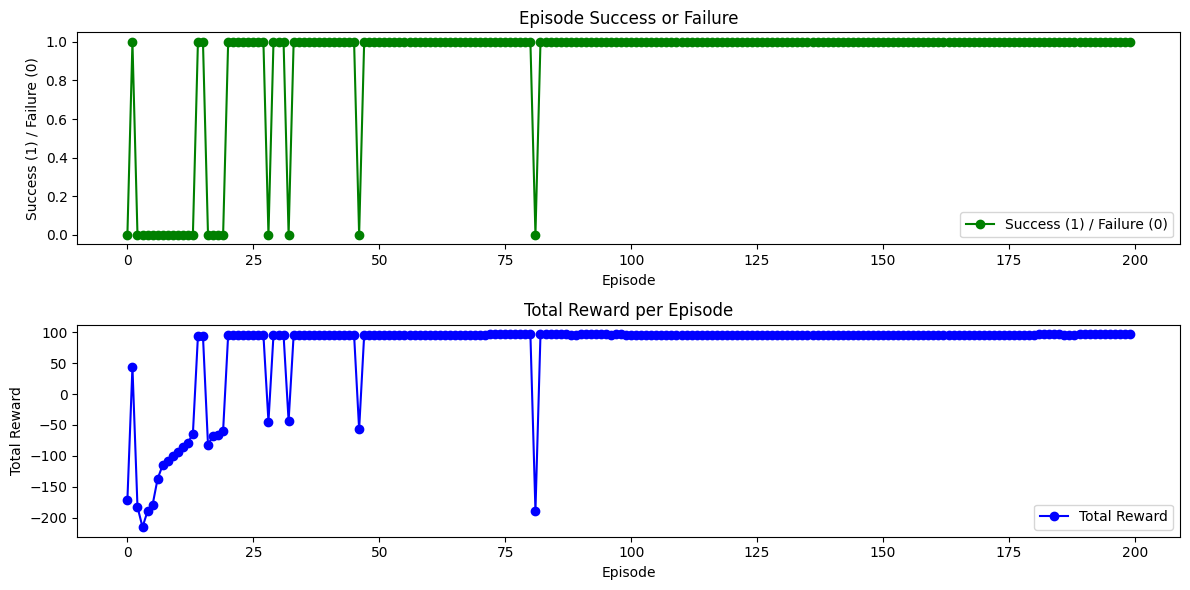

In [32]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(12, 6))

# Plot success/failure
plt.subplot(2, 1, 1)
plt.plot(success, marker='o', linestyle='-', color='green', label="Success (1) / Failure (0)")
plt.xlabel("Episode")
plt.ylabel("Success (1) / Failure (0)")
plt.title("Episode Success or Failure")
plt.legend()

# Plot total reward
plt.subplot(2, 1, 2)
plt.plot(Reward, marker='o', linestyle='-', color='blue', label="Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
main_model.save('two_link_dqn.keras')

In [34]:
# Testing the trained model
test_episodes = 10  # Number of episodes to test
successful_episodes = 0
total_rewards = []

print("\nTesting the Trained Model...\n")

for episode in range(test_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    time_step = 0

    while not done and time_step < 100:  # Limit steps to avoid infinite loops
        # Select action greedily
        action = np.argmax(main_model.predict(state, verbose=0))

        # Take the action in the environment
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Update state and accumulate reward
        state = next_state
        total_reward += reward
        time_step += 1

    # Check if the episode was successful (goal reached)
    if done and time_step < 100:
        successful_episodes += 1

    # Log the total reward for this episode
    total_rewards.append(total_reward)
    print(f"Episode {episode + 1}/{test_episodes}, Total Reward: {total_reward:.2f}, Steps: {time_step}")

# Summary of test results
success_rate = (successful_episodes / test_episodes) * 100
average_reward = np.mean(total_rewards)

print("\nTest Summary:")
print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward: {average_reward:.2f}")
print(f"Successful Episodes: {successful_episodes}/{test_episodes}")



Testing the Trained Model...

Episode 1/10, Total Reward: 96.32, Steps: 5
Episode 2/10, Total Reward: 96.32, Steps: 5
Episode 3/10, Total Reward: 96.32, Steps: 5
Episode 4/10, Total Reward: 96.32, Steps: 5
Episode 5/10, Total Reward: 96.32, Steps: 5
Episode 6/10, Total Reward: 96.32, Steps: 5
Episode 7/10, Total Reward: 96.32, Steps: 5
Episode 8/10, Total Reward: 96.32, Steps: 5
Episode 9/10, Total Reward: 96.32, Steps: 5
Episode 10/10, Total Reward: 96.32, Steps: 5

Test Summary:
Success Rate: 100.00%
Average Reward: 96.32
Successful Episodes: 10/10
